In [1]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
from food_analyzer import fetch_products, clean_data, NutriModel
import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
categories_map = {
    "Légumes": "canned-vegetables",
    "Légumineuses": "legumes",
    "Céréales": "breakfast_cereals",
    "Pizzas": "pizzas",
    "Fromages": "cheeses",
    "Chocolats": "chocolates",
    "Jus de Fruits": "fruit-juices",
    "Biscuits": "biscuits"
}

print("🌍 Lancement de la collecte")
all_data = []

# On récupère 150 produits par catégorie = environ 1200 produits au total
TARGET_PER_CAT = 300 

for label, api_tag in categories_map.items():
    print(f"\n📦 [{label}] Récupération en cours...")
    products = fetch_products(api_tag, target_count=TARGET_PER_CAT)
    
    # On ajoute le label propre pour l'analyse plus tard
    for p in products:
        p['Category_Label'] = label 
        
    all_data.extend(products)
    print(f"   ✅ {len(products)} récupérés.")

# Nettoyage global
df_final = clean_data(all_data)

print("-" * 50)
print(f"🚀 DATASET FINAL : {len(df_final)} produits.")
print("-" * 50)

# Affichage de la diversité
print("Répartition par Catégorie :")
print(df_final['Category_Label'].value_counts())
print("\nRépartition par Nutriscore :")
print(df_final['Nutriscore'].value_counts().sort_index())

🌍 Lancement de la collecte

📦 [Légumes] Récupération en cours...
📡 Démarrage de la collecte pour atteindre 300 produits...
   ... Récupération page 1 (0/300)
   ... Récupération page 2 (50/300)
   ... Récupération page 3 (100/300)
   ❌ Erreur réseau : HTTPSConnectionPool(host='world.openfoodfacts.org', port=443): Read timed out. (read timeout=10)
✅ Collecte terminée : 100 produits récupérés.
   ✅ 100 récupérés.

📦 [Légumineuses] Récupération en cours...
📡 Démarrage de la collecte pour atteindre 300 produits...
   ... Récupération page 1 (0/300)
   ❌ Erreur réseau : HTTPSConnectionPool(host='world.openfoodfacts.org', port=443): Read timed out. (read timeout=10)
✅ Collecte terminée : 0 produits récupérés.
   ✅ 0 récupérés.

📦 [Céréales] Récupération en cours...
📡 Démarrage de la collecte pour atteindre 300 produits...
   ... Récupération page 1 (0/300)
   ❌ Erreur réseau : HTTPSConnectionPool(host='world.openfoodfacts.org', port=443): Read timed out. (read timeout=10)
✅ Collecte terminée

In [4]:
model = NutriModel()
accuracy = model.train(df_final)

print(f"🎯 Précision du modèle : {accuracy:.2%}")

print("Test de prédiction")
test_produit = {
    'Energie': 450, 
    'Sucre': 30, 
    'Gras': 20, 
    'Saturés': 10, 
    'Sel': 0.5, 
    'Fibres': 2, 
    'Protéines': 6
}
note = model.predict(test_produit)
print(f"Un produit avec 30g de sucre et 10g de gras saturés aurait la note : {note}")

🎯 Précision du modèle : 100.00%
Test de prédiction
Un produit avec 30g de sucre et 10g de gras saturés aurait la note : D


/tmp/ipykernel_55751/3484155915.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


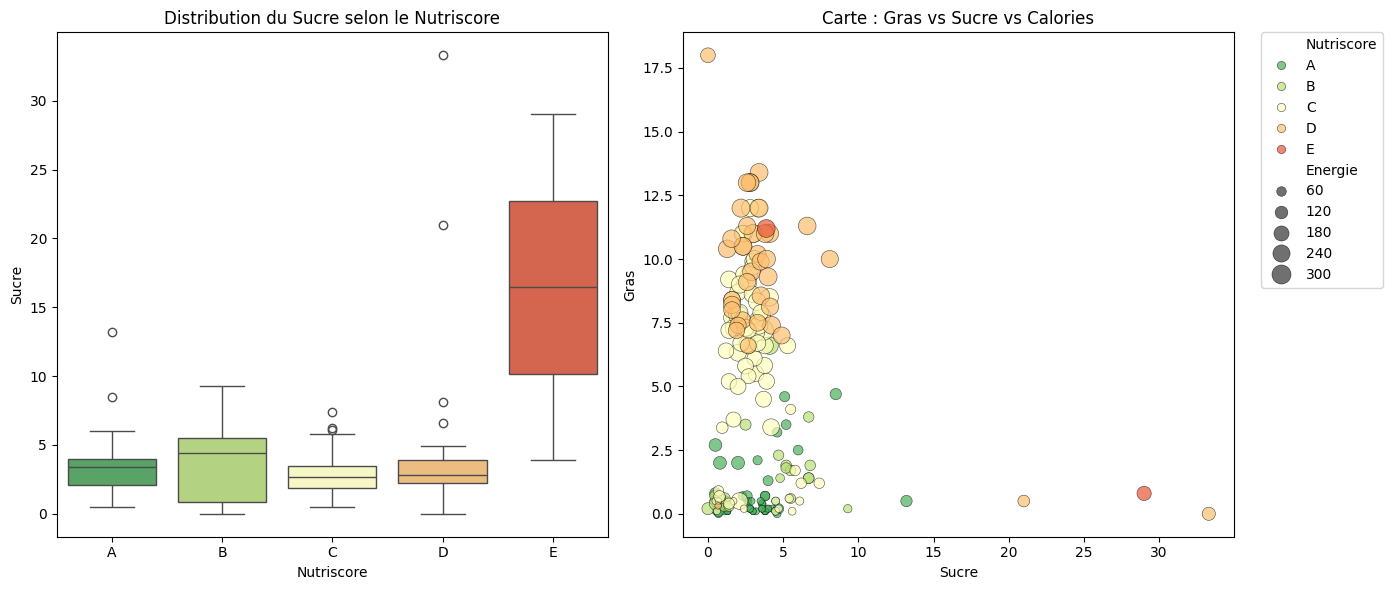

In [5]:
# Visualisation et Analyse

plt.figure(figsize=(14, 6))

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df_final, 
    x='Nutriscore', 
    y='Sucre', 
    palette="RdYlGn_r"
)
plt.title("Distribution du Sucre selon le Nutriscore")

# Analyse multivariée : Relation Gras / Sucre / Calories
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df_final, 
    x="Sucre", 
    y="Gras", 
    hue="Nutriscore",     # La couleur dépend du score
    size="Energie",# La taille du point dépend des calories
    sizes=(20, 200),      # Echelle de taille
    palette="RdYlGn_r",
    alpha=0.7,            # Transparence pour voir les points superposés
    edgecolor="black"
)
plt.title("Carte : Gras vs Sucre vs Calories")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout() # Ajuste automatiquement les marges
plt.show()

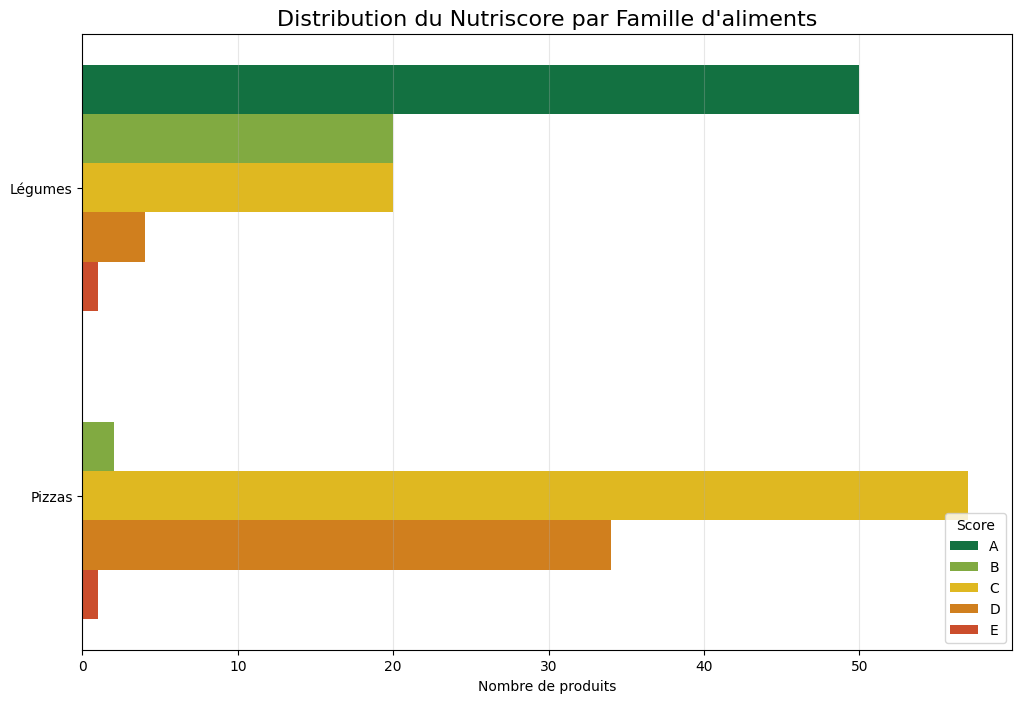

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Palette Nutriscore
nutri_palette = {'A': '#038141', 'B': '#85BB2F', 'C': '#FECB02', 'D': '#EE8100', 'E': '#E63E11'}

plt.figure(figsize=(12, 8))

# Le graphique qui tue : "Qui sont les bons et les mauvais élèves ?"
sns.countplot(
    data=df_final, 
    y='Category_Label', # Catégories sur l'axe vertical
    hue='Nutriscore',   # Couleurs selon la note
    hue_order=['A', 'B', 'C', 'D', 'E'],
    palette=nutri_palette,
    order=df_final['Category_Label'].unique()
)

plt.title("Distribution du Nutriscore par Famille d'aliments", fontsize=16)
plt.xlabel("Nombre de produits")
plt.ylabel("")
plt.legend(title="Score", loc="lower right")
plt.grid(axis='x', alpha=0.3)
plt.show()

In [7]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, widgets

# Palette officielle Nutriscore pour Plotly
color_map = {'A': '#038141', 'B': '#85BB2F', 'C': '#FECB02', 'D': '#EE8100', 'E': '#E63E11'}
category_orders = {"Nutriscore": ["A", "B", "C", "D", "E"]}

choix_categories = ['Toutes'] + sorted(df_final['Category_Label'].unique().tolist())

def visualiser_rapide(categorie):
    # 1. Filtrage (Plus rapide sans .copy())
    if categorie == 'Toutes':
        df_plot = df_final
    else:
        df_plot = df_final[df_final['Category_Label'] == categorie]

    if df_plot.empty:
        print("Aucune donnée.")
        return

    # 2. Création des 2 graphiques côte à côte avec Plotly
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f"Distribution Sucre ({categorie})", f"Gras vs Sucre ({categorie})"),
        horizontal_spacing=0.15
    )

    # --- Gauche : Boxplot (Sucre) ---
    # On itère pour garder les bonnes couleurs car Plotly gère les couleurs différemment en subplot
    for score in ["A", "B", "C", "D", "E"]:
        df_score = df_plot[df_plot['Nutriscore'] == score]
        if not df_score.empty:
            fig.add_trace(
                go.Box(
                    y=df_score['Sucre'], 
                    name=score,
                    marker_color=color_map[score],
                    boxpoints=False, # Enlève les points pour être plus rapide
                    showlegend=False
                ),
                row=1, col=1
            )

    # --- Droite : Scatterplot (Gras vs Sucre) ---
    # Pour le scatter, on utilise une boucle pour mapper les couleurs correctement
    for score in ["A", "B", "C", "D", "E"]:
        df_score = df_plot[df_plot['Nutriscore'] == score]
        if not df_score.empty:
            fig.add_trace(
                go.Scatter(
                    x=df_score['Sucre'],
                    y=df_score['Gras'],
                    mode='markers',
                    name=score,
                    marker=dict(
                        color=color_map[score],
                        size=df_score['Energie'] / 20, # Taille selon calories
                        sizemode='area',
                        sizemin=4,
                        line=dict(width=1, color='DarkSlateGrey')
                    ),
                    text=df_score['Nom'], # <--- LE BONUS : Affiche le nom au survol !
                    hovertemplate="<b>%{text}</b><br>Sucre: %{x}g<br>Gras: %{y}g"
                ),
                row=1, col=2
            )

    # Mise en forme globale
    fig.update_layout(
        height=500, 
        width=1100,
        template="plotly_white",
        title_text=f"Analyse Interactive : {categorie}",
        showlegend=True
    )
    
    # Axes
    fig.update_yaxes(title_text="Sucre (g/100g)", row=1, col=1)
    fig.update_xaxes(title_text="Sucre (g/100g)", row=1, col=2)
    fig.update_yaxes(title_text="Gras (g/100g)", row=1, col=2)

    fig.show()

print("🚀 Affichage interactif haute performance :")
interact(visualiser_rapide, categorie=widgets.Dropdown(options=choix_categories, description='Catégorie:'))

🚀 Affichage interactif haute performance :


interactive(children=(Dropdown(description='Catégorie:', options=('Toutes', 'Légumes', 'Pizzas'), value='Toute…

<function __main__.visualiser_rapide(categorie)>